# English 2 Korean

## Prepare special letter

In [ ]:
space_letter = ' '
special_letters = [space_letter]

## ~~Prepare Korean data~~
모든 한국어 글자를 사용하기엔 너무 많음. 데이터에서 나오는 글자만 사용함.
(하단 셀 참조)

In [ ]:
# Prepare Korean letters
first_id = ord('가')
last_id = ord('힣')

korean_letter_list = [chr(num) for num in range(first_id, last_id+1)]

## Valid checking
try:
    assert len(korean_letter_list) == 11172
except AssertionError:
    print('Wrong!')
    raise
else:
    print('Cool!')
    
# Extend special letters
korean_letter_list.extend(special_letters)

# Make a mapping with index
idx2korean = dict(zip(range(len(korean_letter_list)), korean_letter_list))
korean2idx = dict(zip(korean_letter_list, range(len(korean_letter_list))))

## Prepare English data

In [ ]:
# Prepare English letters
first_big_id = ord('A')
last_big_id = ord('Z')
first_small_id = ord('a')
last_small_id = ord('z')

big = list(range(first_big_id, last_big_id+1))
small = list(range(first_small_id, last_small_id+1))

english_letter_list = [chr(num) for num in big+small]
    
# Extend special letters
english_letter_list.extend(special_letters)
    
# Make a mapping with index
idx2english = dict(enumerate(english_letter_list, 1))
english2idx = {v: k for k, v in idx2english.items()}

## Load dataset from csv

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv('kcrong.csv', encoding='utf8')
del df['Unnamed: 0']

In [ ]:
# Load X
roma = df['roma'].apply(lambda x: np.array([english2idx[letter] for letter in x]))
roma_df = pd.DataFrame(roma)
X = pd.DataFrame(roma_df['roma'].tolist()).values

# Replace nan to 0
# Get index of nan, and make them 0
X[np.isnan(X)] = 0
print(X)

In [ ]:
X.shape

In [ ]:
# Build korean letter set

# 한국어의 모든 글자를 사용하기엔 너무 많음. (가~힣 약 11175개)
# 따라서 이미 등장한 단어만 사용

# 데이터 셋에서 모든 한글 값 가져옴
hang = df['hang'].values

# 등장한 모든 글자의 리스트를 가져오고, set() 으로 중복 제거
korean_letter_list = list(set([letter for sent in hang for letter in sent]))

In [ ]:
# Make a mapping with index
idx2korean = dict(enumerate(korean_letter_list, 1))
korean2idx = {v: k for k, v in idx2korean.items()}

In [ ]:
hang = df['hang'].apply(lambda x: np.array([korean2idx[letter] for letter in x]))
hang_df = pd.DataFrame(hang)
y = pd.DataFrame(hang_df['hang'].tolist()).values

In [ ]:
# Replace nan to 0
# Get index of nan, and make them 0
y[np.isnan(y)] = 0
print(y)
print(y.shape)

In [ ]:
# one-hot encode y
from keras.utils import np_utils

y = np_utils.to_categorical(y, num_classes=len(korean_letter_list)+1).reshape(300, 12, len(korean_letter_list)+1)

In [ ]:
y.shape

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

## Hyper Parameters

In [ ]:
from keras.layers import recurrent

# Parameters for the model and dataset
TRAINING_SIZE = 50000
VOCAB_SIZE = 12
INVERT = True
HIDDEN_SIZE = 200
BATCH_SIZE = 100
LAYERS = 2
MAX_EPOCHS = 1000
EMBEDDING_OUTPUT_SIZE = 128
MAX_SENT_LENGTH = X.shape[1] + 1

# Try replacing with LSTM, GRU, or SimpleRNN
RNN = recurrent.GRU
stop_monitor = 'val_acc'  # variable for early stop: (default = val_loss)
stop_delta = 0.0  # minimum delta before early stop (default = 0)
stop_epochs = 20    # how many epochs to do after stop condition (default = 0)


## Model visualize function

In [37]:
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot

def viz_model(model):
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

## Build Model

In [1]:
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Activation, RepeatVector, Embedding, Dropout

def build_model(embedding_input_dim,
                embedding_output_dim,
                embedding_input_length,
                maximum_input_length,
                hidden_size,
                maximum_output_length,
                encoder_layer_count,
                dropout_rate,
                output_classes_count,
                rnn_layer,
                summary_type=False):
    
    print('Build model...')
    RNN = rnn_layer

    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_input_dim,
        output_dim=embedding_output_dim,
        input_length=embedding_input_length
    ))
    
    model.add(RNN(hidden_size, return_sequences=True, input_shape=(maximum_input_length, 123)))
    model.add(RNN(hidden_size))

    model.add(RepeatVector(maximum_output_length)) # 글자수 맥시멈

    for _ in range(encoder_layer_count):
        model.add(RNN(hidden_size, return_sequences=True))
        model.add(Dropout(dropout_rate))

    # For each of step of the output sequence, decide which character should be chosen
    model.add(TimeDistributed(Dense(output_classes_count)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', # default: categorical_crossentropy
                  optimizer='adam', # default: adam, can try SGD, RMSprop
                  metrics=['accuracy'])
    
    
    
    if summary_type is False:
        pass
    elif str(summary_type).lower() == 'svg':
        viz_model(model)
    else:
        model.summary()
        
    return model

print('Done')

Using TensorFlow backend.


Done


## ~~NO~~ Early Stop

In [ ]:
# Early Stop
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor=stop_monitor,
    min_delta=stop_delta,
    patience=stop_epochs,
    verbose=1,
    mode='auto',
)

# callbacks_list = [early_stop]
callbacks_list = []

## Train model

In [ ]:
## Create model object
model = build_model(summary_type=True)

In [ ]:
hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

In [ ]:
# Visualize history
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label='val loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'r', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
model.evaluate(X_test, y_test)

OVERFITTING....

### Let's insert Dropout 

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

In [ ]:
# Visualize history
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label='val loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'r', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
def number_to_english(data):
    tmp_list = []
    for letter in data:
        try:
            tmp_list.append(idx2english[int(letter)])
        except KeyError:
            break
    return "".join(tmp_list)

def english_to_number(data):
    tmp_list = []
    for letter in data:
        try:
            tmp_list.append(english2idx[letter])
        except KeyError:
            print("I didn't learn %s" % letter)

    return tmp_list
            
def number_to_korean(data):
    tmp_list = []
    for letter in data:
        try:
            tmp_list.append(idx2korean[int(letter)])
        except KeyError:
            break
    return "".join(tmp_list)

def argmax_data(data):
    return [np.argmax(letter) for letter in data]

## Check the result !

In [ ]:
check_length = 10

input_x_values = X_train[[range(check_length)]]
result = model.predict(input_x_values)

for input_x, result_y in zip(input_x_values, result):
    print(number_to_english(input_x))
    print(number_to_korean(argmax_data(result_y)))

In [ ]:
query = "air conditioner"

# convert to index
idx_list = np.array(english_to_number(query), dtype='float')

# Padding trick
idx_list.resize(1, 24)

# Get result
result = model.predict(idx_list, verbose=1)

# Print the query
print("Query: ",query)

# Print the result as Readable for person
print("Answer: ", number_to_korean(argmax_data(result[0])))

In [ ]:
query = "air"

# convert to index
idx_list = np.array(english_to_number(query), dtype='float')

# Padding trick
idx_list.resize(1, 24)

# Get result
result = model.predict(idx_list, verbose=1)

# Print the query
print("Query: ",query)

# Print the result as Readable for person
print("Answer: ", number_to_korean(argmax_data(result[0])))

## Save the Model

In [ ]:
model.save('english2korean.h5')

## Load the Model

In [ ]:
number_to_english(X_train[0])

In [ ]:
from keras.utils import plot_model
from keras.models import load_model

loaded_model = load_model('english2korean.h5')

# plot_model(model, to_file='model.png')

In [ ]:
import numpy as np

In [ ]:
query = "Abel"

# convert to index
idx_list = np.array(english_to_number(query), dtype='float')

# Padding trick
idx_list.resize(1, 24)

# Get result
result = loaded_model.predict(idx_list, verbose=1)

# Print the query
print("Query: ",query)

# Print the result as Readable for person
print("Answer: ", number_to_korean(argmax_data(result[0])))

# Character-level Embedding

글자 `가-힣` 단계에서 output을 뽑는 위 모델과는 다르게, 자음/모음을 출력값으로 가진 뒤에 조합하는 모델

In [5]:
space = [' ']

## Prepare English data

In [6]:
# Prepare English letters
first_big_id = ord('A')
last_big_id = ord('Z')
first_small_id = ord('a')
last_small_id = ord('z')

big = list(range(first_big_id, last_big_id+1))
small = list(range(first_small_id, last_small_id+1))

english_letter_list = [chr(num) for num in big+small] + space
    
# Make a mapping with index
idx2english = dict(enumerate(english_letter_list, 1))
english2idx = {v: k for k, v in idx2english.items()}

## Prepare Korean data

In [7]:
consonants = [chr(letter) for letter in range(ord('ㄱ'), ord('ㅎ')+1)]
vowel = [chr(letter) for letter in range(ord('ㅏ'), ord('ㅣ')+1)]

korean_letter_list = consonants + vowel + space

# Make a mapping with index
idx2korean = dict(enumerate(korean_letter_list, 1))
korean2idx = {v: k for k, v in idx2korean.items()}

In [8]:
import numpy as np
import pandas as pd

df = pd.read_csv('full_data.csv', encoding='utf8')
df['roma'] = df['roman']
df['hang'] = df['hangul']
df.head()
# del df['Unnamed: 0']

,roman,hangul,roma,hang
0,Fiery Cross Reef,파이어리 크로스 리프,Fiery Cross Reef,파이어리 크로스 리프
1,Rosetta,로제타,Rosetta,로제타
2,Lynch Loretta Elizabeth,린치 로레타 엘리자베스,Lynch Loretta Elizabeth,린치 로레타 엘리자베스
3,Crabbe Tim,크래브 팀,Crabbe Tim,크래브 팀
4,Schumacher Nick,슈매커 닉,Schumacher Nick,슈매커 닉


### Load X

In [9]:
roma = df['roma'].apply(lambda x: np.array([english2idx[letter] for letter in x]))
roma_df = pd.DataFrame(roma)
X = pd.DataFrame(roma_df['roma'].tolist()).values

# Replace nan to 0
# Get index of nan, and make them 0
X[np.isnan(X)] = 0
print(X)
print(X.shape)

[[  6.  35.  31. ...,   0.   0.   0.]
 [ 18.  41.  45. ...,   0.   0.   0.]
 [ 12.  51.  40. ...,   0.   0.   0.]
 ..., 
 [ 33.  27.  30. ...,   0.   0.   0.]
 [ 33.  27.  44. ...,   0.   0.   0.]
 [ 33.  27.  44. ...,   0.   0.   0.]]
(11189, 28)


### Load y

In [10]:
# from https://github.com/Kcrong/separate-korean/blob/master/separater.py
class Separater:
    # BASE_CODE, CHOSUNG, JUNGSUNG = 44032, 588, 28
    _BASE_CODE = 44032
    _CHOSUNG = 588
    _JUNGSUNG = 28

    _CHOSUNG_LIST = [u'ㄱ', u'ㄲ', u'ㄴ', u'ㄷ', u'ㄸ', u'ㄹ', u'ㅁ', u'ㅂ', u'ㅃ', u'ㅅ', u'ㅆ', u'ㅇ', u'ㅈ', u'ㅉ', u'ㅊ', u'ㅋ',
                     u'ㅌ', u'ㅍ', u'ㅎ']
    _JUNGSUNG_LIST = [u'ㅏ', u'ㅐ', u'ㅑ', u'ㅒ', u'ㅓ', u'ㅔ', u'ㅕ', u'ㅖ', u'ㅗ', u'ㅘ', u'ㅙ', u'ㅚ', u'ㅛ', u'ㅜ', u'ㅝ', u'ㅞ',
                      u'ㅟ', u'ㅠ', u'ㅡ', u'ㅢ', u'ㅣ']
    _JONGSUNG_LIST = [u' ', u'ㄱ', u'ㄲ', u'ㄳ', u'ㄴ', u'ㄵ', u'ㄶ', u'ㄷ', u'ㄹ', u'ㄺ', u'ㄻ', u'ㄼ', u'ㄽ', u'ㄾ', u'ㄿ', u'ㅀ',
                      u'ㅁ', u'ㅂ', u'ㅄ', u'ㅅ', u'ㅆ', u'ㅇ', u'ㅈ', u'ㅊ', u'ㅋ', u'ㅌ', u'ㅍ', u'ㅎ']

    ch = _BASE_CODE + (0 * _CHOSUNG + 2 * _JUNGSUNG)

    def __init__(self, word):
        self.word = word

    @property
    def sep_all(self):
        try:
            _all_ = list()

            for ch in self.word:
                for tmp in ch:
                    chbase = ord(tmp) - Separater._BASE_CODE

                    ch_1 = chbase // Separater._CHOSUNG
                    _all_.append(Separater._CHOSUNG_LIST[ch_1])

                    ch_2 = (chbase - (Separater._CHOSUNG * ch_1)) // Separater._JUNGSUNG
                    _all_.append(Separater._JUNGSUNG_LIST[ch_2])

                    ch_3 = (chbase - (Separater._CHOSUNG * ch_1) - (Separater._JUNGSUNG * ch_2))
                    _all_.append(Separater._JONGSUNG_LIST[ch_3])

            while True:
                try:
                    _all_.remove(' ')
                except ValueError:
                    break
        except:
            print(self.word)
            raise
                    
        return _all_

    @property
    def chosung(self):
        all_chosung = list()
        for ch in self.word:
            for tmp in ch:
                all_chosung.append(Separater._CHOSUNG_LIST[((ord(tmp) - Separater._BASE_CODE) // Separater._CHOSUNG)])
        return all_chosung

    @property
    def jungsung(self):
        all_jungsung = list()

        for ch in self.word:
            for tmp in ch:
                chbase = ord(tmp) - Separater._BASE_CODE
                jungsung_idx = (chbase - (Separater._CHOSUNG * (chbase // Separater._CHOSUNG))) // Separater._JUNGSUNG
                all_jungsung.append(Separater._JUNGSUNG_LIST[jungsung_idx])
        return all_jungsung

    @property
    def jongsung(self):
        all_jongsung = list()

        for ch in self.word:
            for tmp in ch:
                chbase = ord(tmp) - Separater._BASE_CODE
                c_idx = chbase // Separater._CHOSUNG

                jongsung_idx = (chbase - (Separater._CHOSUNG * c_idx) - (
                    Separater._JUNGSUNG * ((chbase - (Separater._CHOSUNG * c_idx)) // Separater._JUNGSUNG)))
                all_jongsung.append(Separater._JONGSUNG_LIST[jongsung_idx])
        return all_jongsung

In [11]:
def sep_encode_all(sent):
    return [korean2idx[let] for letter in sent if letter != ' ' for let in Separater(letter).sep_all]

def sep_all(sent):
    return [let for letter in sent if letter != ' ' for let in Separater(letter).sep_all]

def encode_all(sep_sent):
    return [korean2idx[let] for let in sep_sent]

assert encode_all(sep_all('안녕 하세요')) == sep_encode_all('안녕 하세요')

In [12]:
# Load y
hang = df['hang'].apply(lambda x: sep_encode_all(x))

# Padding Trick. Add nan automatically
hang_df = pd.DataFrame(hang)
y = pd.DataFrame(hang_df['hang'].tolist()).values

# nan to 0
y[np.isnan(y)] = 0

print(y)
print(y.shape)

[[ 29.  31.  23. ...,   0.   0.   0.]
 [  9.  39.  24. ...,   0.   0.   0.]
 [  9.  51.   4. ...,   0.   0.   0.]
 ..., 
 [  1.  31.   7. ...,   0.   0.   0.]
 [  1.  31.   4. ...,   0.   0.   0.]
 [  1.  31.   4. ...,   0.   0.   0.]]
(11189, 30)


In [13]:
# one-hot encoding
from keras.utils import np_utils

y = np_utils.to_categorical(y, num_classes=len(korean_letter_list)+1).reshape(y.shape[0], y.shape[1], len(korean_letter_list)+1)

In [14]:
y.shape

(11189, 30, 53)

### Split train & test & validation set

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

## Build & Train model

In [19]:
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot

def viz_model(model):
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Activation, RepeatVector, Embedding, Dropout

def build_model(embedding_input_dim,
                embedding_output_dim,
                embedding_input_length,
                maximum_input_length,
                hidden_size,
                maximum_output_length,
                encoder_layer_count,
                dropout_rate,
                output_classes_count,
                rnn_layer,
                summary_type=False):
    
    print('Build model...')
    RNN = rnn_layer

    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_input_dim,
        output_dim=embedding_output_dim,
        input_length=embedding_input_length
    ))
    
    model.add(RNN(hidden_size, return_sequences=True, input_shape=(maximum_input_length, 123)))
    model.add(RNN(hidden_size))

    model.add(RepeatVector(maximum_output_length)) # 글자수 맥시멈

    for _ in range(encoder_layer_count):
        model.add(RNN(hidden_size, return_sequences=True))
        model.add(Dropout(dropout_rate))

    # For each of step of the output sequence, decide which character should be chosen
    model.add(TimeDistributed(Dense(output_classes_count)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', # default: categorical_crossentropy
                  optimizer='adam', # default: adam, can try SGD, RMSprop
                  metrics=['accuracy'])
    
    
    
    if summary_type is False:
        pass
    elif str(summary_type).lower() == 'svg':
        viz_model(model)
    else:
        model.summary()
        
    return model

print('Done')

Done


In [21]:
from keras.layers import recurrent

model = build_model(
    embedding_input_dim=len(english_letter_list)+1,  # Add 1 because of padding
    embedding_output_dim=200,
    embedding_input_length=X.shape[1],
    maximum_input_length=X.shape[1],
    hidden_size = 200,
    maximum_output_length=y.shape[1],  # Add 1 because of last chr. 마지막 패딩 출력을 위해,
    encoder_layer_count=2,  # Make 2 layers for encoding layer
    dropout_rate=0.2, # Make no-dropout
    output_classes_count=len(korean_letter_list)+1,  # Add 1 because of padding
    rnn_layer=recurrent.GRU,
    summary_type=True
)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 28, 200)           10800     
_________________________________________________________________
gru_13 (GRU)                 (None, 28, 200)           240600    
_________________________________________________________________
gru_14 (GRU)                 (None, 200)               240600    
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 30, 200)           0         
_________________________________________________________________
gru_15 (GRU)                 (None, 30, 200)           240600    
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
gru_16 (GRU)                 (None, 30, 200)           240600

In [25]:
## Params

BATCH_SIZE=64
MAX_EPOCHS=100

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    verbose=1
)

Train on 7048 samples, validate on 784 samples
Epoch 1/100
7048/7048 [==============================] - 8s - loss: 1.3135 - acc: 0.7031 - val_loss: 1.0997 - val_acc: 0.7193
Epoch 2/100
7048/7048 [==============================] - 7s - loss: 1.0515 - acc: 0.7196 - val_loss: 0.9905 - val_acc: 0.7239
Epoch 3/100
7048/7048 [==============================] - 7s - loss: 0.9907 - acc: 0.7260 - val_loss: 0.9744 - val_acc: 0.7291
Epoch 4/100
7048/7048 [==============================] - 7s - loss: 0.9309 - acc: 0.7352 - val_loss: 0.9301 - val_acc: 0.7321
Epoch 5/100
7048/7048 [==============================] - 7s - loss: 0.9099 - acc: 0.7360 - val_loss: 0.9001 - val_acc: 0.7363
Epoch 6/100
7048/7048 [==============================] - 7s - loss: 0.8994 - acc: 0.7380 - val_loss: 0.9040 - val_acc: 0.7369
Epoch 7/100
7048/7048 [==============================] - 7s - loss: 0.8948 - acc: 0.7384 - val_loss: 0.8963 - val_acc: 0.7372
Epoch 8/100
7048/7048 [==============================] - 7s - loss: 0.8

In [29]:
hist2.history['loss']

[0.092786252633938054,
 0.084843806592614368,
 0.10074032412653748,
 0.096561266618879107,
 0.072834398291971233,
 0.072016498135248463,
 0.05865065379662357,
 0.062743712846659097,
 0.058412685411031888,
 0.061961973126170043,
 0.085761299020654089,
 0.066430493952467543,
 0.07656145227330903,
 0.078425144043060765,
 0.082060973237138596,
 0.062968125168305994,
 0.048720408121079514,
 0.041397358321507594,
 0.05001379251818381,
 0.073632024858616266,
 0.14807636073444813,
 0.11778501607266241,
 0.07641093127607082,
 0.062228863739602007,
 0.055939549282108612,
 0.041551248246019495,
 0.044343871701927377,
 0.070916062056020357,
 0.056179544678069945,
 0.049725167127696125]

In [21]:
model.evaluate(X_test, y_test)

3357/3357 [==============================] - 1s     


[0.54901867985973973, 0.91450703211543738]

## Viz history (Within Dropout)

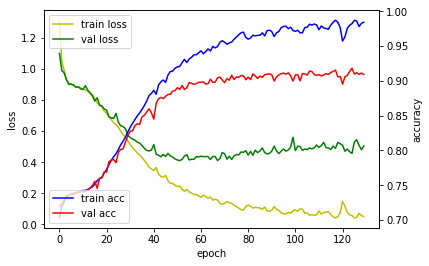

In [30]:
# Visualize history
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label='val loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'r', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Viz history (Without Dropout)

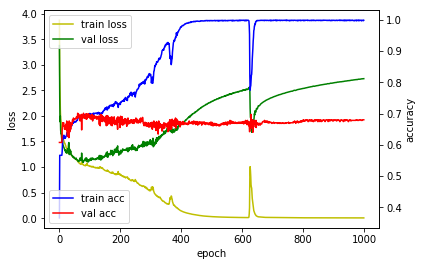

In [128]:
# Visualize history
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label='val loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'r', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Viz history (Within Dropout, Large Dataset)

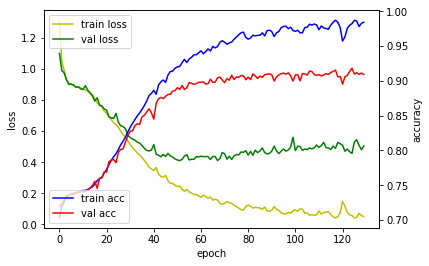

In [31]:
# Visualize history
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'] + hist2.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'] + hist2.history['val_loss'], 'g', label='val loss')
acc_ax.plot(hist.history['acc'] + hist2.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'] + hist2.history['val_acc'], 'r', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Change model 
Tips from paper (https://arxiv.org/abs/1409.0473)

1. non-bidirectional LSTM in encoder.
2. reverse the input (np.flip)
3. pad from the start. 

Before:  
X --> y  
[h, e, l, l, o, PAD, PAD] --> [안, 녕, 하, 세, 요]  

After:  
X --> y  
[PAD, PAD, o, l, l, e, h] >>> [안, 녕, 하, 세, 요]  

## Ready dataset

In [42]:
# Reverse Input
new_X = np.flip(X, axis=1)

array([  6.,  35.,  31.,  44.,  51.,  53.,   3.,  44.,  41.,  45.,  45.,
        53.,  18.,  31.,  31.,  32.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.])

## Build model

In [38]:
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Activation, RepeatVector, Embedding, Dropout

def build_model(embedding_input_dim,
                embedding_output_dim,
                embedding_input_length,
                maximum_input_length,
                hidden_size,
                maximum_output_length,
                encoder_layer_count,
                dropout_rate,
                output_classes_count,
                input_rnn_layer,
                output_rnn_layer,
                summary_type=False):
    
    print('Build model...')
    ENCODER_RNN = input_rnn_layer
    DECODER_RNN = output_rnn_layer

    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_input_dim,
        output_dim=embedding_output_dim,
        input_length=embedding_input_length
    ))
    
    model.add(ENCODER_RNN(hidden_size, return_sequences=True, input_shape=(maximum_input_length, 123)))
    model.add(ENCODER_RNN(hidden_size))

    model.add(RepeatVector(maximum_output_length)) # 글자수 맥시멈

    for _ in range(encoder_layer_count):
        model.add(DECODER_RNN(hidden_size, return_sequences=True))
        model.add(Dropout(dropout_rate))

    # For each of step of the output sequence, decide which character should be chosen
    model.add(TimeDistributed(Dense(output_classes_count)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', # default: categorical_crossentropy
                  optimizer='adam', # default: adam, can try SGD, RMSprop
                  metrics=['accuracy'])
    
    
    
    if summary_type is False:
        pass
    elif str(summary_type).lower() == 'svg':
        viz_model(model)
    else:
        model.summary()
        
    return model

print('Done')

Done


In [2]:
from keras.layers import recurrent

model = build_model(
    embedding_input_dim=len(english_letter_list)+1,  # Add 1 because of padding
    embedding_output_dim=200,
    embedding_input_length=X.shape[1],
    maximum_input_length=X.shape[1],
    hidden_size = 200,
    maximum_output_length=y.shape[1],  # Add 1 because of last chr. 마지막 패딩 출력을 위해,
    encoder_layer_count=2,  # Make 2 layers for encoding layer
    dropout_rate=0.2, # Make no-dropout
    output_classes_count=len(korean_letter_list)+1,  # Add 1 because of padding
    input_rnn_layer=recurrent.LSTM,
    output_rnn_layer=recurrent.GRU,
    summary_type='svg'
)

NameError: name 'build_model' is not defined

In [51]:
## Params

BATCH_SIZE=64
MAX_EPOCHS=150

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    verbose=1
)

Train on 7048 samples, validate on 784 samples
Epoch 1/100
7048/7048 [==============================] - 9s - loss: 1.2900 - acc: 0.7046 - val_loss: 1.2348 - val_acc: 0.7106
Epoch 2/100
7048/7048 [==============================] - 8s - loss: 1.0133 - acc: 0.7227 - val_loss: 1.0297 - val_acc: 0.7189
Epoch 3/100
7048/7048 [==============================] - 8s - loss: 0.9858 - acc: 0.7260 - val_loss: 0.9723 - val_acc: 0.7259
Epoch 4/100
7048/7048 [==============================] - 8s - loss: 0.9382 - acc: 0.7341 - val_loss: 0.9080 - val_acc: 0.7350
Epoch 5/100
7048/7048 [==============================] - 8s - loss: 0.9057 - acc: 0.7365 - val_loss: 0.9147 - val_acc: 0.7348
Epoch 6/100
7048/7048 [==============================] - 8s - loss: 0.9051 - acc: 0.7371 - val_loss: 0.9007 - val_acc: 0.7369
Epoch 7/100
7048/7048 [==============================] - 8s - loss: 0.9032 - acc: 0.7372 - val_loss: 0.9343 - val_acc: 0.7364
Epoch 8/100
7048/7048 [==============================] - 8s - loss: 0.8

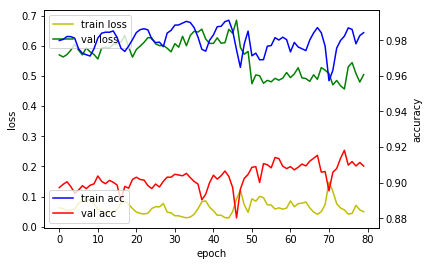

In [55]:
# Visualize history
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'] + hist2.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'] + hist2.history['val_loss'], 'g', label='val loss')
acc_ax.plot(hist.history['acc'] + hist2.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'] + hist2.history['val_acc'], 'r', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

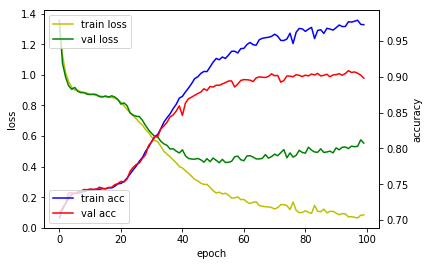

In [59]:
# Visualize history
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(data['loss'], 'y', label='train loss')
loss_ax.plot(data['val_loss'], 'g', label='val loss')
acc_ax.plot(data['acc'], 'b', label='train acc')
acc_ax.plot(data['val_acc'], 'r', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [1]:
## Params
from keras_tqdm import TQDMNotebookCallback

BATCH_SIZE=64
MAX_EPOCHS=150

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    verbose=1,
    callbacks=[TQDMNotebookCallback()]
)

Using TensorFlow backend.


NameError: name 'model' is not defined